In [15]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from implementations import *
from utilitaries import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Data Cleaning
===

In [16]:
from proj1_helpers import *

labels, features, indices = load_csv_data('train.csv', sub_sample=False)
# b(background) -> -1 and s(signal) -> 1

n_samples, n_features = np.shape(features)
features = remove_meaningless_data(features)

print(n_samples, n_features)


250000 30


In [17]:
prop_nan = np.zeros((2,30))

for i in range(n_features):
    n_nan = 0
    for j in range(n_samples):
        if np.isnan(features[j,i]):
            n_nan += 1
    prop_nan[0,i] = i
    prop_nan[1,i] = n_nan/n_samples

print(prop_nan)

[[ 0.        1.        2.        3.        4.        5.        6.
   7.        8.        9.       10.       11.       12.       13.
  14.       15.       16.       17.       18.       19.       20.
  21.       22.       23.       24.       25.       26.       27.
  28.       29.      ]
 [ 0.152456  0.        0.        0.        0.709828  0.709828  0.709828
   0.        0.        0.        0.        0.        0.709828  0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.399652  0.399652  0.399652  0.709828  0.709828
   0.709828  0.      ]]


In [18]:
clean_data = np.delete(features, np.s_[0,4,5,6,12,23,24,25,26,27,28], axis=1)

print(np.shape(clean_data))

# 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
# 0 1 2 3       4 5 6 7  8     9  10 11 12 13 14 15 16 17 18                   19 

std_data = standardize(clean_data)
print(std_data)

s_data = std_data[labels == 1,:]
bg_data = std_data[labels == -1,:]

(250000, 19)
[[ 0.06833197  0.40768027 -0.46996624 ...  0.38684673  1.04440205
   0.4125105 ]
 [ 0.55250482  0.54013641 -0.15316749 ... -0.35771893  0.02130497
  -0.27381996]
 [ 3.19515553  1.09655998 -0.34970965 ...  0.40013535  0.02130497
  -0.29396985]
 ...
 [ 0.31931645 -0.13086367 -0.28495489 ... -0.08608887  0.02130497
  -0.31701723]
 [-0.84532397 -0.30297338 -0.69737766 ... -0.76742886 -1.00179211
  -0.74543941]
 [ 0.66533608 -0.25352276 -0.79202769 ... -0.87267059 -1.00179211
  -0.74543941]]


Features selection
===

IndexError: index 19 is out of bounds for axis 1 with size 19

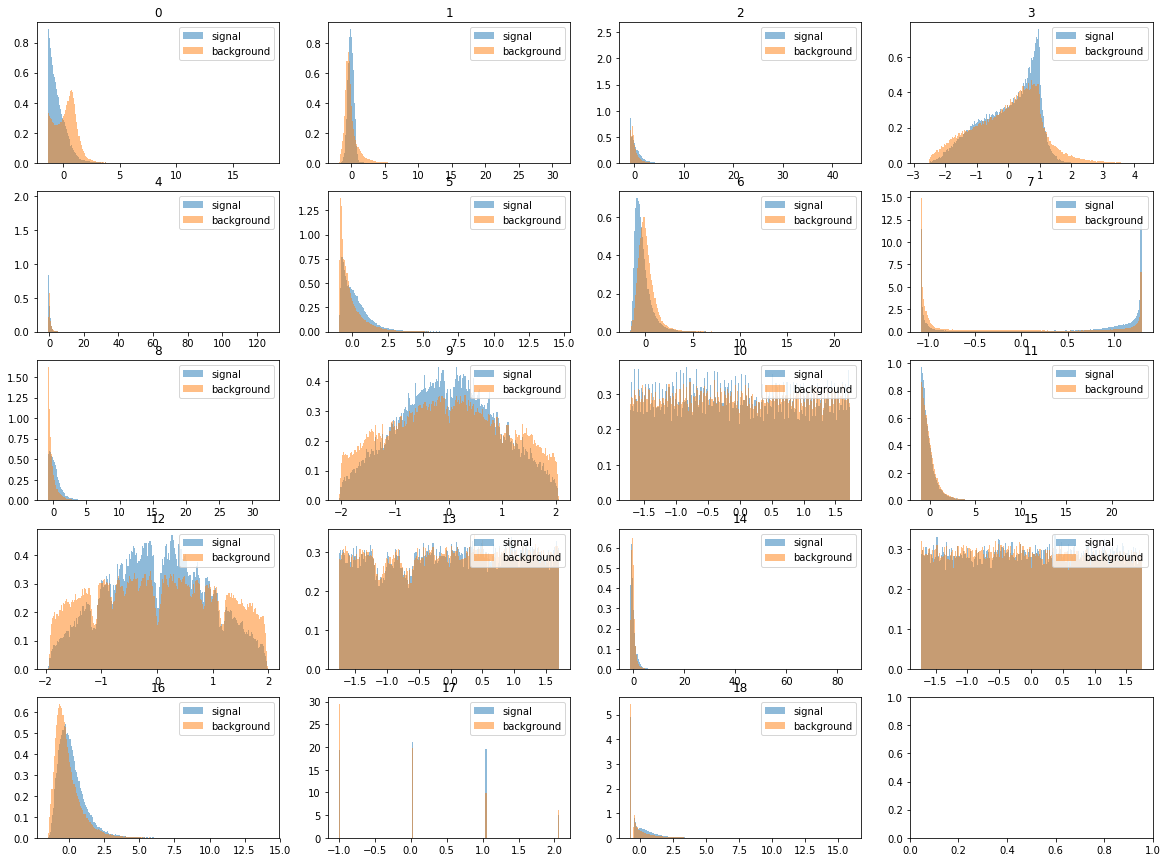

In [19]:
plt.figure(figsize=(20,15))

pics = 200

for i in range(20):
    plt.subplot(5,4,i+1)
    plt.hist(s_data[:,i][~np.isnan(s_data[:,i])], pics, density=1, alpha=0.5, label='signal')
    plt.hist(bg_data[:,i][~np.isnan(bg_data[:,i])], pics, density=1, alpha=0.5, label='background')
    plt.legend(loc='upper right')
    plt.title(i)

In [20]:
#inutile = 10 (14), 11 (15), 12 (16), 13(17), 14 (18), 16 (20), 17 (21) (same distribution)--> need to be tested with model

In [42]:
from additional_functions import *
def ridge_regression_demo(std_data,labels,degree,ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, -1, 10)
    # split data
    x_tr, x_te, y_tr, y_te = split_data(std_data,labels,ratio, seed)
    # form tx
    tx_tr = build_poly(x_tr, degree)
    tx_te = build_poly(x_te, degree)
    # ridge regression with different lambda
    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
         # ridge regression
            weight_tr,loss_tr = ridge_regression(y_tr, tx_tr, lambda_)
            weight_te,loss_te = ridge_regression(y_te, tx_te, lambda_)
            rmse_tr.append(np.sqrt(2 * loss_tr))
            rmse_te.append(np.sqrt(2 * loss_te))

            #print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               #p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

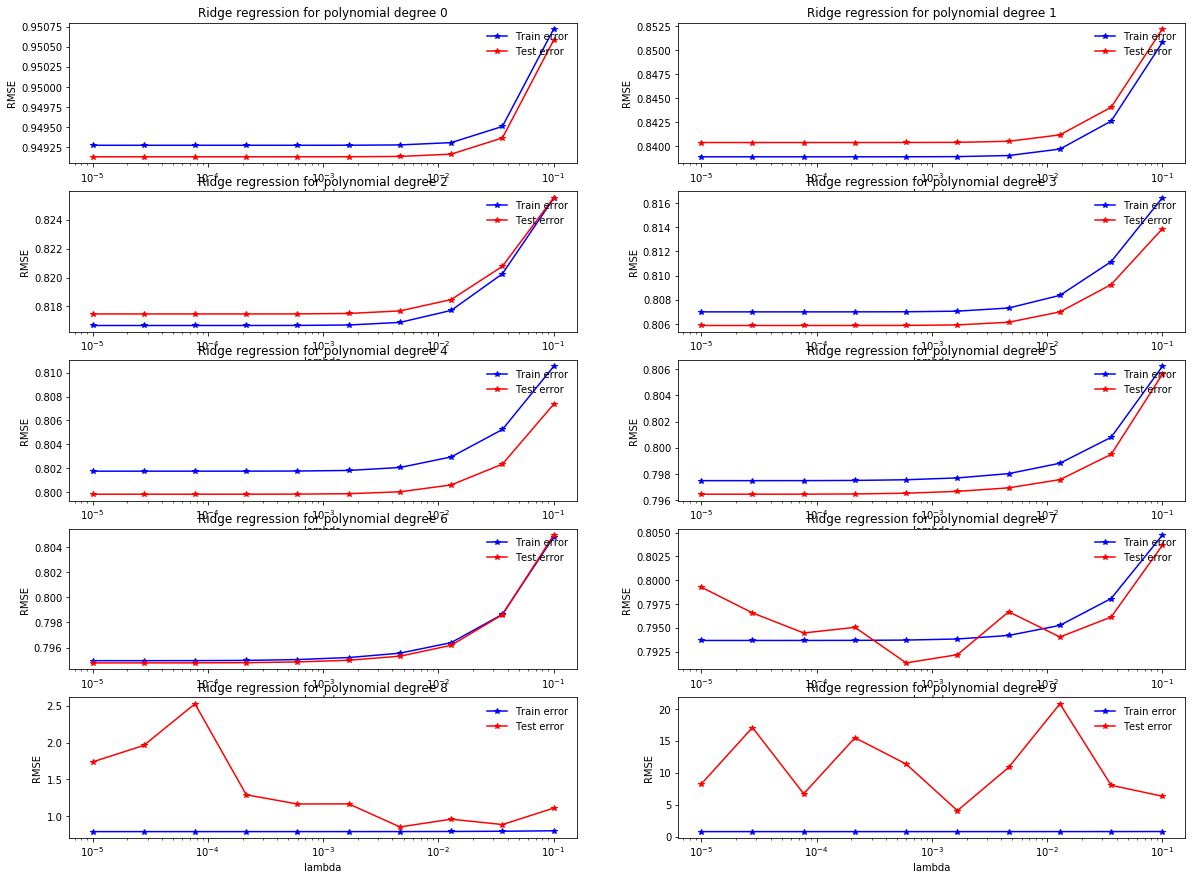

In [43]:
seed = 56
split_ratio = 0.5
plt.figure(figsize=(20,15))

for degree in range(10):
    plt.subplot(5,2,degree+1)
    ridge_regression_demo(std_data,labels, degree, split_ratio, seed)


In [48]:
#ideas to search the hyperparameters
from grid_search import *
